## Introduction

This dataset consists of 101 animals from a zoo. There are 16 variables with various traits to describe the animals. The 7 Class Types are: Mammal, Bird, Reptile, Fish, Amphibian, Bug and Invertebrate

The purpose for this dataset is to be able to predict the classification of the animals, based upon the variables. It is the perfect dataset for those who are new to learning Machine Learning. 

Practice TensorFlow.

Attribute Information: (name of attribute and type of value domain)

- animal_name: Unique for each instance
- hair Boolean
- feathers Boolean
- eggs Boolean
- milk Boolean
- airborne Boolean
- aquatic Boolean
- predator Boolean
- toothed Boolean
- backbone Boolean
- breathes Boolean
- venomous Boolean
- fins Boolean
- legs Numeric (set of values: {0,2,4,5,6,8})
- tail Boolean
- domestic Boolean
- catsize Boolean
- class_type Numeric (integer values in range [1,7])


## Import libraries

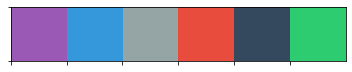

In [1]:
# Toolbox
import pandas as pd
import numpy as np
import random
import sys
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import norm

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Misc
import os
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 1000
pd.options.display.max_rows =1000
pd.set_option('display.max_columns', 50)

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite code to use: #34995e

In [2]:
import tensorflow as tf
import tensorflow.keras
import keras

print('These are the current versions working for me as of 2019-08-04')
print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Keras Version: {tensorflow.keras.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print("TensorFlow-GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print(f"TensorFlow CUDA: {tf.test.is_built_with_cuda()}")
print(f"Tensorflow GPU Device Currently Activated: {tf.test.gpu_device_name()}")
print(f"Keras GPU: {keras.backend.tensorflow_backend._get_available_gpus()}")
print()
print(f"TF Session: {tf.Session()}")
print()
print(f"Python {sys.version}")

Using TensorFlow backend.


These are the current versions working for me as of 2019-08-04
TensorFlow Version: 1.13.1
TensorFlow Keras Version: 2.2.4-tf
Keras Version: 2.2.4

TensorFlow-GPU is available
TensorFlow CUDA: True
Tensorflow GPU Device Currently Activated: /device:GPU:0
Keras GPU: ['/job:localhost/replica:0/task:0/device:GPU:0']

TF Session: <tensorflow.python.client.session.Session object at 0x000001D010A0F668>

Python 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


### Define functions

In [3]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get Values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    plt.figure(figsize=(12, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()

## Load data

In [4]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\MachineLearning\\Data'
os.chdir(PATH)
os.getcwd()
os.listdir()

['01-ign.csv',
 '02-winequality-red.csv',
 '02-winequality-white.csv',
 '03-thanksgiving-2015-poll-data.csv',
 '05-ibm-sales-loss.csv',
 '07-test.csv',
 '07-train.csv',
 '09-house-regression-env.db',
 '09-house-test.csv',
 '09-house-train.csv',
 '10-vgsales.csv',
 '11-diabetes.csv',
 '13-facebook-likes.csv',
 '15-google-review-ratings.csv',
 '16-mnist-test.csv',
 '16-mnist-train.csv',
 '17-real-estate-valuation.csv',
 '18-credit-card-defaults.csv',
 '20-zoo.csv',
 '21-breast-cancer.csv',
 'README.md']

In [5]:
train = pd.read_csv('20-zoo.csv')

In [6]:
train.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [7]:
train.shape

(101, 18)

In [8]:
train.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644,2.831683
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314,2.102709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,2.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,7.000000


In [9]:
get_nulls(train)

There are 0 columns with missing values.


,Null Data Count,Null Data Pct


### Classes

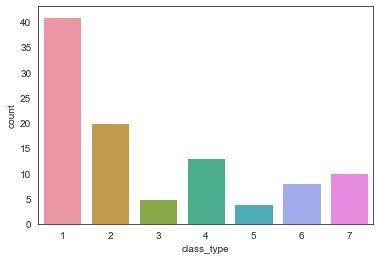

In [10]:
sns.countplot(train.class_type, label='Counts')
plt.show()

Frequency of class_type :


,Count,Percentage
1,41,40.59
2,20,19.80
4,13,12.87
7,10,9.90
6,8,7.92
3,5,4.95
5,4,3.96


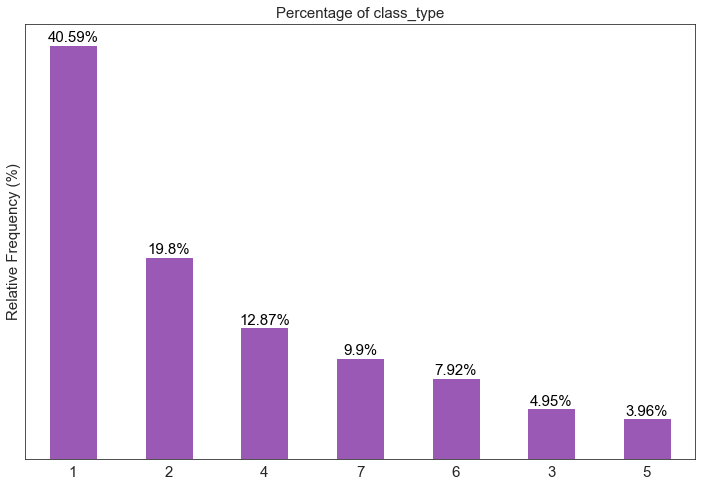

In [11]:
freq_table(train.class_type)

### Correlation

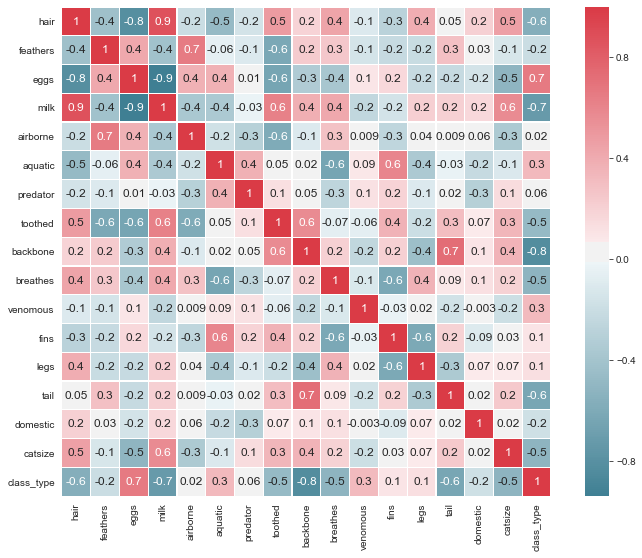

In [12]:
# Create a figure space
plt.subplots(figsize=(12,9))

# Color
colormap = sns.diverging_palette(220, 10, as_cmap = True) # nice colors

# Create matrix
corr_plot = sns.heatmap(train.corr(),
                        annot=True,
                        cmap=colormap, #'viridis', # YlGnBu, RdBu_r
                        linewidths=0.20,
                        linecolor='white',
                        vmax=1,
                        square=True,
                        fmt='.1g',
                        annot_kws={"size": 12})
corr_plot
plt.show()

- In statistics, the correlation coefficient r measures the strength and direction of a linear relationship. don't get this mixed upwith coefficient of determination which is the r^2 which shows percentage of variation in y which is explained by the x variables.
    - when Pearson's r is close to 1 that means there is a strong relationship between the two variables
    - when Pearson's r is close to 0 that means there is a weak relationship between the two variables

### Coefficient of Determination (R-Squared)

The coefficient of determination provides a 'goodness of fit' measure for the predictions to the observations. This is a value between 0 and 1. It's the proportion of the variance in the dependent variable (y) that is predictable from the independent variable (x).

In [13]:
# Top numeric features
r_squared = train.corr()**2
pd.DataFrame(r_squared.class_type.sort_values(ascending=False))

,class_type
class_type,1.000000
backbone,0.686984
milk,0.523716
eggs,0.438013
tail,0.399209
hair,0.316275
catsize,0.271473
breathes,0.269681
toothed,0.222338
aquatic,0.106693


### Modeling preparation

In [14]:
# Split data
y = train[['class_type']]
X = train.drop('class_type', axis=1)

In [15]:
print('Feature Data: ', X.shape)
print('Label Data: ', y.shape)

Feature Data:  (101, 17)
Label Data:  (101, 1)


In [16]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100, stratify=y)

In [17]:
print('Training Data Shape:', X_train.shape)
print('Testing Data Shape:', X_test.shape)

print('Training Output Shape:', y_train.shape)
print('Testing Output Shape:', y_test.shape)

Training Data Shape: (70, 17)
Testing Data Shape: (31, 17)
Training Output Shape: (70, 1)
Testing Output Shape: (31, 1)


In [18]:
# Get animal name after stratifying data
train_name = X_train['animal_name']
test_name = X_test['animal_name']

# Drop animal_name
X_train = X_train.iloc[:,1:]
X_test = X_test.iloc[:,1:]

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape:', X_test.shape)

Training Data Shape: (70, 16)
Testing Data Shape: (31, 16)


## TensorFlow

tf.nn.softmax_cross_entropy_with_logits_v2 - Computes softmax cross entropy between logits and labels

https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2

In [19]:
# Define model parameters
learning_rate = 0.05

# Define how many inputs and outputs are in our neural network
number_of_inputs = 16
number_of_outputs = 1
seed = 100

# Number of nodes in each layer
layer_1_nodes = 7

# Define X / Y variables
X = tf.placeholder(tf.float32, shape=[None, number_of_inputs]) 
Y = tf.placeholder(tf.int32, shape=[None, number_of_outputs])

# Change Y format using one_hot() and reshape into 7 factor levels
# Change y_data form into y - one hot encoding form
Y_one_hot = tf.one_hot(Y, 7)
Y_one_hot = tf.reshape(Y_one_hot, [-1, 7]) # -1 means no size limits of rows & 7 columns

# Create weights and biases
weights = tf.Variable(tf.random_normal(shape=[number_of_inputs, layer_1_nodes], seed=seed, name='weight1'))
biases = tf.Variable(tf.random_normal(shape=[layer_1_nodes], seed=seed, name='biases1'))

# Create output (weight * input + bias)
layer_1_output = tf.nn.softmax(tf.matmul(X, weights) + biases)

# Create cost (takes outputs)
cost_i = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_1_output, labels=Y_one_hot)
cost = tf.reduce_mean(cost_i)

# Create optimizer (takes costs)
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
# # Change y_train format using one_hot() and reshape into 7 factor levels
# y_train_ohe = tf.one_hot(y_train, 7)
# y_train_ohe = tf.reshape(y_train_ohe, [-1, 7]) # -1 means no size limits of rows & 7 columns

# y_test_ohe = tf.one_hot(y_test, 7)
# y_test_ohe = tf.reshape(y_test_ohe, [-1, 7])

## Prediction
tf.argmax() - since layer_1_output is 7 classes, you have to find max softmax results. (It returns the index value of the array with the largest probability)

In [21]:
prediction = tf.argmax(layer_1_output, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # call this later + cost

## Initialize session

In [22]:
accuracy_summary = [] 
loss_summary = [] 
stop_early = 0 

In [23]:
################################################
####### Initialize Session
################################################

# Initialize a training session after defining the model
with tf.Session() as session:
    
    # Run the global variable initializer to initialize all variables/layers in the neural network
    session.run(tf.global_variables_initializer())
    
    # Training
    for epoch in range(10001):
        session.run(train, feed_dict={X: X_train, Y: y_train})
        
        # Show result
        if epoch % 500 == 0:
            
            # Run session with training data
            loss, acc = session.run([cost, accuracy], feed_dict={X: X_train, Y: y_train})
            print('Epoch: {:5}\tLoss: {:.3f}\tAcc: {:.2%}'.format(epoch, loss, acc))
            
            # Record the results
            loss_summary.append(loss)
            accuracy_summary.append(acc)
            
            # If the model does not improve, stop the training
            if loss < max(loss_summary) and epoch > 100:
                stop_early+=1
                
                # Stop after 10 times
                if stop_early==10:
                    break
                else:
                    stop_early=0
            
    # Get accuracy
    train_acc = session.run(accuracy, feed_dict={X: X_train, Y: y_train})
    test_acc, test_predict, test_correct = session.run([accuracy, prediction, correct_prediction], feed_dict={X: X_test, Y: y_test})
    
    # Print results
    print('='*50)
    print('Finished, Results Below:')
    print('Training Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)

Epoch:     0	Loss: 1.876	Acc: 1.43%
Epoch:   500	Loss: 1.560	Acc: 38.57%
Epoch:  1000	Loss: 1.543	Acc: 40.00%
Epoch:  1500	Loss: 1.505	Acc: 41.43%
Epoch:  2000	Loss: 1.435	Acc: 52.86%
Epoch:  2500	Loss: 1.421	Acc: 52.86%
Epoch:  3000	Loss: 1.416	Acc: 52.86%
Epoch:  3500	Loss: 1.413	Acc: 52.86%
Epoch:  4000	Loss: 1.411	Acc: 52.86%
Epoch:  4500	Loss: 1.410	Acc: 52.86%
Epoch:  5000	Loss: 1.409	Acc: 52.86%
Epoch:  5500	Loss: 1.409	Acc: 52.86%
Epoch:  6000	Loss: 1.408	Acc: 52.86%
Epoch:  6500	Loss: 1.408	Acc: 52.86%
Epoch:  7000	Loss: 1.407	Acc: 52.86%
Epoch:  7500	Loss: 1.407	Acc: 52.86%
Epoch:  8000	Loss: 1.407	Acc: 52.86%
Epoch:  8500	Loss: 1.407	Acc: 52.86%
Epoch:  9000	Loss: 1.406	Acc: 52.86%
Epoch:  9500	Loss: 1.406	Acc: 52.86%
Epoch: 10000	Loss: 1.406	Acc: 52.86%
Finished, Results Below:
Training Accuracy:  0.5285714
Test Accuracy:  0.5483871


In [24]:
# Submission
submission = pd.DataFrame()
submission['Name'] = test_name
submission['Predict_Type'] = test_predict
submission['Origin_Type'] = y_test
submission['Correct'] = test_correct
submission

,Name,Predict_Type,Origin_Type,Correct
100,wren,4,2,False
58,penguin,4,2,False
43,lark,4,2,False
21,duck,4,2,False
10,cheetah,1,1,True
40,housefly,1,6,False
50,mongoose,1,1,True
4,boar,1,1,True
87,swan,4,2,False
80,slowworm,1,3,False
